In [1]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from trash_data import TRASH_AVG, TRASH_STD
import matplotlib.pyplot as plt

%matplotlib widget

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_15552/191935504.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [15]:
# parameters
W_p = TRASH_AVG*7*10**3
SIGMA_p = TRASH_STD*7*10**3
SIGMA_c = np.array([0.87015967, 0.87015967, 0.87015967, 0.87015967, 0.87024291,
       0.87022626, 0.87022626, 0.87022626, 0.87022626, 0.87024291,
       0.87015967, 0.87022626])*10**3
P = np.array([78380,92445,163141,131351,63600,155614,222129,231983,110458,130440,125771,180206])/10**3
A = np.floor(np.array([40710976, 37719022, 46882269, 49291774, 43796730, 38695300, 53154204, 55045848, 41892850, 39080798, 66146445, 77969957])/10.764/10**6)
N_total = 1000
Z_min = 5
Z_max = 10
Q_bound = 4
R = 12*10**3
MAX_ITERATION = 500

In [16]:
reset_params()


Cost = 1438.0 with Q = 7.744564176515902e-13
	 Q = 7.744564176515902e-13 is minimized with 0 steps at: [ 67.  73. 143. 101.  59. 107. 176. 186.  99. 126. 114. 187.]

Cost = 1405.0 with Q = 5.125210068008046e-09
	 Q = 5.125210068008046e-09 is minimized with 0 steps at: [ 65.  72. 139. 100.  57. 105. 173. 183.  97. 122. 112. 180.]

Cost = 1389.0 with Q = 2.4075792259563714e-07
	 Q = 2.4075792259563714e-07 is minimized with 0 steps at: [ 65.  72. 138.  99.  56. 105. 172. 182.  96. 120. 112. 172.]

Cost = 1381.0 with Q = 1.0385695862282302e-06
	 Q = 1.0385695862282302e-06 is minimized with 0 steps at: [ 64.  71. 137.  98.  55. 104. 171. 181.  95. 119. 111. 175.]

Cost = 1377.0 with Q = 9.902932346309753e-07
	 Q = 9.902932346309753e-07 is minimized with 0 steps at: [ 64.  71. 136.  98.  55. 104. 170. 180.  95. 119. 111. 174.]

Cost = 1375.0 with Q = 1.3493961403673905e-06
	 Q = 1.3493961403673905e-06 is minimized with 0 steps at: [ 64.  71. 136.  98.  55. 104. 170. 180.  95. 118. 111. 173.

In [4]:
#Calculate lower bound for each district
lower = np.ceil((2*R*W_p+Z_min**2*SIGMA_c**2+((2*R*W_p+Z_min**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_min**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

#Calculate upper bound for each district
upper = np.floor((2*R*W_p+Z_max**2*SIGMA_c**2+((2*R*W_p+Z_max**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_max**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

#bounds for C
C_min = np.sum(lower)
C_max = np.sum(upper)

# constants
SQRT_2 = np.sqrt(2)
SQRT_2_OVER_PI = np.sqrt(2/np.pi)

# whether the upper bound is too lose
if np.sum(upper)>12*N_total:
    print("upper bound is too lose")

#compute Q
def Q(T):
    mu = W_p-R*T
    sigma = np.sqrt(SIGMA_p**2+SIGMA_c**2*T)
    delta = 1/2*(mu*erf(mu/(SQRT_2*sigma))+mu+SQRT_2_OVER_PI*sigma*np.exp(-mu**2/(2*sigma**2)))
    S = np.average(delta/(A*P))
    return np.sqrt(1/12*np.sum((delta/(A*P)-S)**2))

#use hill climbing algorithm to find the minimum Q
def findMin(T_11,C, iterations):
    #if the number of iterations is greater than maximum iterations, return
    if iterations > MAX_ITERATION:
        print("\t Max iterations reached")
        return False
    # append the 12th index to T_11 to make T
    T = np.append(T_11, C-np.sum(T_11))
    # compute Q
    Q_current = Q(T)
    # whether there the current is within the constraint for Q
    if Q_current <= Q_bound:
        print("\t Q = "+str(Q_current)+" is minimized with "+str(iterations)+" steps at: " + str(T))
        return True
    
    # record minimum Q and the move that minimize Q
    Q_min = Q_current 
    #target_move[0] is the index to change, target_move[1] is the direction of change, either -1 or 1, 0 means not moving
    target_move = [0,0] 
    
    # iterate through all possible moves
    for i in range(11):
        for j in [-1,1]:
            # whether the new condition lie within the upper and lower bounds for each index
            if lower[i]<=T[i]+j and T[i]+j <= upper[i] and lower[11]<=T[11]-j and T[11]-j <= upper[11]:
                # the new schedule
                T_new = T
                T_new[i]+=j
                T_new[11]-=j
                # compute Q for the new schedule
                Q_new = Q(T_new)
                
                # If the new schedule has a lower Q, than record that move
                if Q_new < Q_min:
                    target_move = [i,j]
                    Q_min = Q_new
        
    # is not moving is the best option, then the current Q is minimum
    if target_move[1] == 0:
        print("\t Q = "+str(Q_current)+" is minimized with "+str(iterations)+" steps at: " + str(T))
        return False
    
    # do the move
    T_11_new = T_11
    T_11_new[target_move[0]]+=target_move[1]
    
    # iterate
    return findMin(T_11_new, C, iterations+1)

#Check whether the cost has any possible schedule within the constraint
def valid(C):
    #initial position
    T_11 = np.round((upper[:11]-lower[:11])*(C-C_min)/(C_max-C_min))+lower[:11]
    print("\nCost = " + str(C)+ " with Q = "+str(Q(np.append(T_11, C-np.sum(T_11)))))
    return findMin(T_11,C,0) 

#Binary search

left = C_min
right = C_max

while left < right:
    mid = (left + right) // 2
    if valid(mid):
        right = mid
    else:
        left = mid+1

print("Cost boundary: " + str(C_min)+"<= Cost <="+str(C_max))
print("The minimum cost is : "+str(left))

def findMin(T_11,C, iterations):
    # append the 12th index to T_11 to make T
    T = np.append(T_11, C-np.sum(T_11))
    # compute Q
    Q_current = Q(T)

    #if the number of iterations is greater than maximum iterations, return
    if iterations > MAX_ITERATION:
        return Q_current
    
    # record minimum Q and the move that minimize Q
    Q_min = Q_current 
    #target_move[0] is the index to change, target_move[1] is the direction of change, either -1 or 1, 0 means not moving
    target_move = [0,0] 
    
    # iterate through all possible moves
    for i in range(11):
        for j in [-1,1]:
            # whether the new condition lie within the upper and lower bounds for each index
            if lower[i]<=T[i]+j and T[i]+j <= upper[i] and lower[11]<=T[11]-j and T[11]-j <= upper[11]:
                # the new schedule
                T_new = T
                T_new[i]+=j
                T_new[11]-=j
                # compute Q for the new schedule
                Q_new = Q(T_new)
                
                # If the new schedule has a lower Q, than record that move
                if Q_new < Q_min:
                    target_move = [i,j]
                    Q_min = Q_new
    
    # if not moving is the best option, then the current Q is minimum               
    if target_move[1] == 0:
        return  Q_current
    
    
    # do the move
    T_11_new = T_11
    T_11_new[target_move[0]]+=target_move[1]
    
    # iterate
    return findMin(T_11_new, C, iterations+1)
    
    

#Check whether the cost has any possible schedule within the constraint
def min_Q(C):
    #initial position
    T_11 = np.round((upper[:11]-lower[:11])*(C-C_min)/(C_max-C_min))+lower[:11]
    #random initial position
    #T_11 = np.array([np.random.randint(l, u + 1) for l, u in zip(lower[:11], upper[:11])])
    return findMin(T_11,C,0) 

def reset_params():

    #Calculate lower bound for each district
    lower = np.ceil((2*R*W_p+Z_min**2*SIGMA_c**2+((2*R*W_p+Z_min**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_min**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

    #Calculate upper bound for each district
    upper = np.floor((2*R*W_p+Z_max**2*SIGMA_c**2+((2*R*W_p+Z_max**2*SIGMA_c**2)**2-4*R**2*(W_p**2-Z_max**2*SIGMA_p**2))**(1/2))/(2*R**2)) 

    #bounds for C
    C_min = np.sum(lower)
    C_max = np.sum(upper)

    # constants
    SQRT_2 = np.sqrt(2)
    SQRT_2_OVER_PI = np.sqrt(2/np.pi)

    # whether the upper bound is too lose
    if np.sum(upper)>12*N_total:
        print("upper bound is too lose")

    #compute Q
    def Q(T):
        mu = W_p-R*T
        sigma = np.sqrt(SIGMA_p**2+SIGMA_c**2*T)
        delta = 1/2*(mu*erf(mu/(SQRT_2*sigma))+mu+SQRT_2_OVER_PI*sigma*np.exp(-mu**2/(2*sigma**2)))
        S = np.average(delta/(A*P))
        return np.sqrt(1/12*np.sum((delta/(A*P)-S)**2))

    #use hill climbing algorithm to find the minimum Q
    def findMin(T_11,C, iterations):
        #if the number of iterations is greater than maximum iterations, return
        if iterations > MAX_ITERATION:
            print("\t Max iterations reached")
            return False
        # append the 12th index to T_11 to make T
        T = np.append(T_11, C-np.sum(T_11))
        # compute Q
        Q_current = Q(T)
        # whether there the current is within the constraint for Q
        if Q_current <= Q_bound:
            print("\t Q = "+str(Q_current)+" is minimized with "+str(iterations)+" steps at: " + str(T))
            return True
        
        # record minimum Q and the move that minimize Q
        Q_min = Q_current 
        #target_move[0] is the index to change, target_move[1] is the direction of change, either -1 or 1, 0 means not moving
        target_move = [0,0] 
        
        # iterate through all possible moves
        for i in range(11):
            for j in [-1,1]:
                # whether the new condition lie within the upper and lower bounds for each index
                if lower[i]<=T[i]+j and T[i]+j <= upper[i] and lower[11]<=T[11]-j and T[11]-j <= upper[11]:
                    # the new schedule
                    T_new = T
                    T_new[i]+=j
                    T_new[11]-=j
                    # compute Q for the new schedule
                    Q_new = Q(T_new)
                    
                    # If the new schedule has a lower Q, than record that move
                    if Q_new < Q_min:
                        target_move = [i,j]
                        Q_min = Q_new
            
        # is not moving is the best option, then the current Q is minimum
        if target_move[1] == 0:
            print("\t Q = "+str(Q_current)+" is minimized with "+str(iterations)+" steps at: " + str(T))
            return False
        
        # do the move
        T_11_new = T_11
        T_11_new[target_move[0]]+=target_move[1]
        
        # iterate
        return findMin(T_11_new, C, iterations+1)

    #Check whether the cost has any possible schedule within the constraint
    def valid(C):
        #initial position
        T_11 = np.round((upper[:11]-lower[:11])*(C-C_min)/(C_max-C_min))+lower[:11]
        print("\nCost = " + str(C)+ " with Q = "+str(Q(np.append(T_11, C-np.sum(T_11)))))
        return findMin(T_11,C,0) 

    #Binary search

    left = C_min
    right = C_max

    while left < right:
        mid = (left + right) // 2
        if valid(mid):
            right = mid
        else:
            left = mid+1

    print("Cost boundary: " + str(C_min)+"<= Cost <="+str(C_max))
    print("The minimum cost is : "+str(left))

    def findMin(T_11,C, iterations):
        # append the 12th index to T_11 to make T
        T = np.append(T_11, C-np.sum(T_11))
        # compute Q
        Q_current = Q(T)

        #if the number of iterations is greater than maximum iterations, return
        if iterations > MAX_ITERATION:
            return Q_current
        
        # record minimum Q and the move that minimize Q
        Q_min = Q_current 
        #target_move[0] is the index to change, target_move[1] is the direction of change, either -1 or 1, 0 means not moving
        target_move = [0,0] 
        
        # iterate through all possible moves
        for i in range(11):
            for j in [-1,1]:
                # whether the new condition lie within the upper and lower bounds for each index
                if lower[i]<=T[i]+j and T[i]+j <= upper[i] and lower[11]<=T[11]-j and T[11]-j <= upper[11]:
                    # the new schedule
                    T_new = T
                    T_new[i]+=j
                    T_new[11]-=j
                    # compute Q for the new schedule
                    Q_new = Q(T_new)
                    
                    # If the new schedule has a lower Q, than record that move
                    if Q_new < Q_min:
                        target_move = [i,j]
                        Q_min = Q_new
        
        # if not moving is the best option, then the current Q is minimum               
        if target_move[1] == 0:
            return  Q_current
        
        
        # do the move
        T_11_new = T_11
        T_11_new[target_move[0]]+=target_move[1]
        
        # iterate
        return findMin(T_11_new, C, iterations+1)
        
        

    #Check whether the cost has any possible schedule within the constraint
    def min_Q(C):
        #initial position
        T_11 = np.round((upper[:11]-lower[:11])*(C-C_min)/(C_max-C_min))+lower[:11]
        #random initial position
        #T_11 = np.array([np.random.randint(l, u + 1) for l, u in zip(lower[:11], upper[:11])])
        return findMin(T_11,C,0) 



Cost = 1297.0 with Q = 0.2494345287652068
	 Q = 0.2494345287652068 is minimized with 0 steps at: [ 60.  67. 128.  94.  50. 100. 162. 172.  90. 108. 107. 159.]

Cost = 1265.0 with Q = 1.6735596317534969
	 Q = 1.6735596317534969 is minimized with 0 steps at: [ 59.  66. 124.  92.  49.  98. 158. 169.  88. 104. 106. 152.]

Cost = 1249.0 with Q = 5.737269340896325
	 Q = 4.52005878212687 is minimized with 2 steps at: [ 59.  66. 123.  92.  48.  98. 157. 168.  87. 102. 106. 143.]

Cost = 1257.0 with Q = 3.299876334348712
	 Q = 3.299876334348712 is minimized with 0 steps at: [ 59.  66. 124.  92.  48.  98. 158. 168.  87. 103. 106. 148.]

Cost = 1253.0 with Q = 3.333841697131063
	 Q = 3.333841697131063 is minimized with 0 steps at: [ 59.  66. 123.  92.  48.  98. 157. 168.  87. 103. 106. 146.]

Cost = 1251.0 with Q = 4.950393921840871
	 Q = 4.400008571933151 is minimized with 2 steps at: [ 59.  66. 123.  92.  48.  98. 157. 168.  87. 102. 106. 145.]

Cost = 1252.0 with Q = 4.820209334623094
	 Q = 4

In [14]:
MAX_ITERATION = 600

def findMin(T_11,C, iterations):
    # append the 12th index to T_11 to make T
    T = np.append(T_11, C-np.sum(T_11))
    # compute Q
    Q_current = Q(T)

    #if the number of iterations is greater than maximum iterations, return
    if iterations > MAX_ITERATION:
        return Q_current
    
    # record minimum Q and the move that minimize Q
    Q_min = Q_current 
    #target_move[0] is the index to change, target_move[1] is the direction of change, either -1 or 1, 0 means not moving
    target_move = [0,0] 
    
    # iterate through all possible moves
    for i in range(11):
        for j in [-1,1]:
            # whether the new condition lie within the upper and lower bounds for each index
            if lower[i]<=T[i]+j and T[i]+j <= upper[i] and lower[11]<=T[11]-j and T[11]-j <= upper[11]:
                # the new schedule
                T_new = T
                T_new[i]+=j
                T_new[11]-=j
                # compute Q for the new schedule
                Q_new = Q(T_new)
                
                # If the new schedule has a lower Q, than record that move
                if Q_new < Q_min:
                    target_move = [i,j]
                    Q_min = Q_new
    
    # if not moving is the best option, then the current Q is minimum               
    if target_move[1] == 0:
        return  Q_current
    
    
    # do the move
    T_11_new = T_11
    T_11_new[target_move[0]]+=target_move[1]
    
    # iterate
    return findMin(T_11_new, C, iterations+1)
    
    

#Check whether the cost has any possible schedule within the constraint
def min_Q(C):
    #initial position
    T_11 = np.round((upper[:11]-lower[:11])*(C-C_min)/(C_max-C_min))+lower[:11]
    #random initial position
    #T_11 = np.array([np.random.randint(l, u + 1) for l, u in zip(lower[:11], upper[:11])])
    return findMin(T_11,C,0) 

$\sigma_{c} =  R \sqrt{P(1-P)}$

$\mathcal{P} = P_{\text{truck not breaking down per week}} \cdot P_{\text{Good Weather}} $

$P_1 = 0.99975$ 

In [21]:
P_flood_annual = np.array([0.01, 0.01, 0.01, 0.01, 0, 0.002, 0.002, 0.002, 0.002, 0, 0.01, 0.002])
P_flood_week = P_flood_annual / 52
P_truck_break_week = 1-0.99975
P_civil_disruptions_week = 1.1/208

P = (1-P_truck_break_week) * (1-P_flood_week) * P_civil_disruptions_week
sigmas = 12 * np.sqrt(P * (1-P))

In [22]:
sigmas

array([0.87015967, 0.87015967, 0.87015967, 0.87015967, 0.87024291,
       0.87022626, 0.87022626, 0.87022626, 0.87022626, 0.87024291,
       0.87015967, 0.87022626])

In [17]:
CC = range(int(C_min),int(C_max)+1)
QQ = []


for i in CC:
    #compute minimum Q for each cost
    QQ.append(min_Q(i))

Qsmooth = gaussian_filter(QQ, 5)

In [18]:

plt.plot(CC, Qsmooth)
plt.plot(CC, QQ)

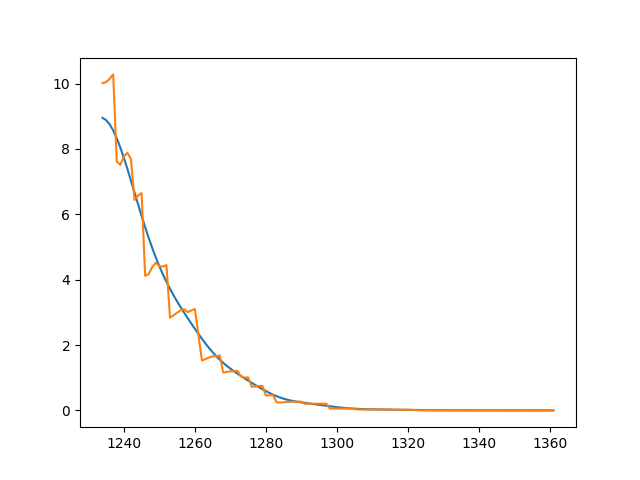

In [14]:
plt.figure()
plt.plot(CC, Qsmooth)
plt.plot(CC, QQ)

In [30]:
dqdc = np.diff(Qsmooth) / np.diff(C)
dcdq = np.diff(C) / np.diff(Qsmooth)


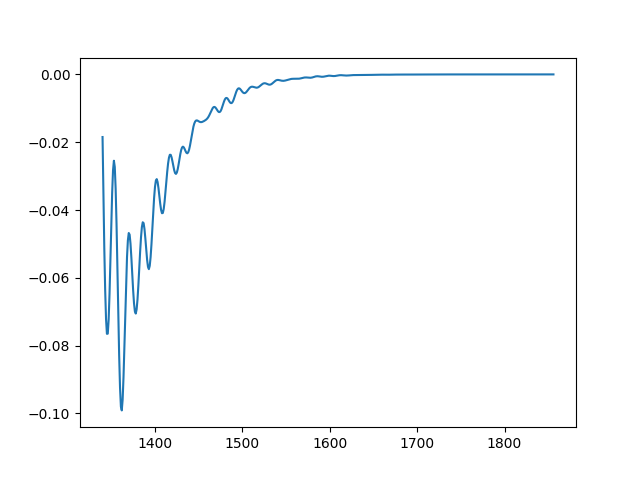

In [35]:
plt.figure()
plt.plot(C[:-1], dqdc)
#plt.plot(Qsmooth[:-1], dcdq)
